# Ejercicio 2

### Introducción

Busque una base de datos de “alta dimensión” (mínimo 5 variables/dimensiones) que le interese, idealmente en neuro, pero puede ser en LO QUE QUIERAN! Utilizando PCA, t-SNE, y otro método no desarrollado (aunque capaz si mencionado) en clase:
Aplicar los métodos de reducción de dimensiones para reducir los datos a 2 o 3 dimensiones y visualizarlos. (35%)
Sacar conclusiones interpretando los datos reducidos: (35%)
¿Qué tipo de relaciones ve entre las variables? (ej. Variables que están correlacionadas, clusters y relaciones entre ellos, etc.)
¿Cómo varían los resultados entre las herramientas? ¿Qué ventajas/desventajas encuentran entre ellos?

---


### Dataset elegido
Para este ejercicio, se tomaron los datos de producción diaria (medida en metros cuadrados de tela) de 7 máquinas distintas de una empresa textil (MS1, MS2, MS3, MS4, MS1n, MS2n, y MS3n) a lo largo de los últimos 4 años. La información se encuentra en un archivo .csv llamado `prodmtsxmaquina.csv`, el cual cuenta con 8 columnas (una para cada máquina y una extra para indicar la fecha) y 1250 filas. 

#### Importamos librerias utiles

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
import pandas as pd
from sklearn.decomposition import PCA, NMF
from sklearn.manifold import TSNE

#### Leemos y preprocesamos los datos

In [2]:
DATA_FILEPATH = 'prodmtsxmaquina.csv'
raw_data = pd.read_csv(DATA_FILEPATH, sep=',')
raw_data = raw_data.fillna(0) 

print(raw_data.columns)
print(raw_data.shape)
raw_data.head(10)

Index(['FECHA', 'MS1', 'MS2', 'MS3', 'MS4', 'MS1n', 'MS2n', 'MS3n'], dtype='object')
(1249, 8)


,FECHA,MS1,MS2,MS3,MS4,MS1n,MS2n,MS3n
0,2020-10-23 00:00:00,1174,1062.0,620,0,1250.0,1124.0,1215.0
1,2020-10-24 00:00:00,979,1049.0,878,1003,0.0,0.0,0.0
2,2020-10-25 00:00:00,0,0.0,0,0,0.0,0.0,0.0
3,2020-10-26 00:00:00,822,947.0,768,587,1030.0,918.0,957.0
4,2020-10-27 00:00:00,644,1026.0,969,360,489.0,624.0,871.0
5,2020-10-28 00:00:00,853,1039.0,589,771,1008.0,932.0,562.0
6,2020-10-29 00:00:00,877,1011.0,531,1240,871.0,882.0,565.0
7,2020-10-30 00:00:00,976,1053.0,901,1017,1008.0,939.0,845.0
8,2020-10-31 00:00:00,605,905.0,445,1595,0.0,0.0,0.0
9,2020-11-01 00:00:00,0,0.0,0,0,618.0,860.0,489.0


Existen días en los que alguna máquina, o incluso todas, NO trabajan. Se eliminarán estos datos para reducir el ruido

In [3]:
columns_to_check = raw_data.columns[1:]
raw_data = raw_data[(raw_data[columns_to_check] > 0).all(axis=1)]

print(raw_data.shape)
raw_data.head(10)

(571, 8)


,FECHA,MS1,MS2,MS3,MS4,MS1n,MS2n,MS3n
3,2020-10-26 00:00:00,822,947.0,768,587,1030.0,918.0,957.0
4,2020-10-27 00:00:00,644,1026.0,969,360,489.0,624.0,871.0
5,2020-10-28 00:00:00,853,1039.0,589,771,1008.0,932.0,562.0
6,2020-10-29 00:00:00,877,1011.0,531,1240,871.0,882.0,565.0
7,2020-10-30 00:00:00,976,1053.0,901,1017,1008.0,939.0,845.0
10,2020-11-02 00:00:00,912,1640.0,622,1419,873.0,1198.0,558.0
14,2020-11-06 00:00:00,1041,1043.0,1127,200,835.0,1061.0,1313.0
25,2020-11-17 00:00:00,709,1014.0,1095,716,876.0,948.0,823.0
26,2020-11-18 00:00:00,882,1108.0,572,1898,959.0,1211.0,789.0
27,2020-11-19 00:00:00,796,1120.0,783,1537,1200.0,1003.0,569.0


Para trabajar en un formato apropiado para el análisis de PCA, eliminamos la primera columna (fechas) y nos quedamos solo con las muestras

In [4]:
# extraemos la fecha desde el df original
raw_data['FECHA'] = pd.to_datetime(raw_data['FECHA'])
fechas = raw_data['FECHA']

# nos quedamos con los datos a analizar
prod_data = raw_data.drop('FECHA', axis=1)
prod_data.head(10)


,MS1,MS2,MS3,MS4,MS1n,MS2n,MS3n
3,822,947.0,768,587,1030.0,918.0,957.0
4,644,1026.0,969,360,489.0,624.0,871.0
5,853,1039.0,589,771,1008.0,932.0,562.0
6,877,1011.0,531,1240,871.0,882.0,565.0
7,976,1053.0,901,1017,1008.0,939.0,845.0
10,912,1640.0,622,1419,873.0,1198.0,558.0
14,1041,1043.0,1127,200,835.0,1061.0,1313.0
25,709,1014.0,1095,716,876.0,948.0,823.0
26,882,1108.0,572,1898,959.0,1211.0,789.0
27,796,1120.0,783,1537,1200.0,1003.0,569.0


Finalmente, estandarizamos los datos dividiéndolos por su desviación estándar

In [5]:
# prod_data = prod_data.sub(prod_data.mean())
prod_data = prod_data.div(prod_data.std())
prod_data.head(10)

,MS1,MS2,MS3,MS4,MS1n,MS2n,MS3n
3,2.879253,3.206231,3.406236,1.957200,3.631172,2.998008,3.981980
4,2.255765,3.473699,4.297712,1.200327,1.723925,2.037862,3.624143
5,2.987838,3.517713,2.612335,2.570700,3.553613,3.043730,2.338425
6,3.071904,3.422914,2.355093,4.134459,3.070632,2.880439,2.350908
7,3.418675,3.565112,3.996118,3.390923,3.553613,3.066590,3.515959
10,3.194500,5.552502,2.758696,4.731288,3.077683,3.912433,2.321781
14,3.646353,3.531256,4.998474,0.666848,2.943717,3.465018,5.463260
25,2.483443,3.433071,4.856548,2.387317,3.088259,3.095982,3.424420
26,3.089418,3.751324,2.536936,6.328390,3.380868,3.954889,3.282949
27,2.788182,3.791952,3.472764,5.124729,4.230492,3.275602,2.367551


## Análisis por PCA

In [6]:
# Realizar el analisis de PCA con sklearn
N = len(prod_data.columns)
pca = PCA(n_components=N)
pca.fit(prod_data)
pca_transformed_data = pca.transform(prod_data)

for idx, component in enumerate(pca.components_):
    print(f'Component {idx + 1} =')
    print('[', ', '.join([f"{val:.3f}" for val in component]), ']')

Component 1 =
[ -0.429, -0.436, -0.286, -0.316, -0.437, -0.388, -0.321 ]
Component 2 =
[ -0.209, -0.164, 0.671, -0.124, -0.229, -0.218, 0.603 ]
Component 3 =
[ -0.512, 0.324, -0.007, 0.546, -0.477, 0.325, -0.032 ]
Component 4 =
[ 0.196, -0.210, 0.101, 0.721, 0.069, -0.602, -0.144 ]
Component 5 =
[ -0.175, -0.547, -0.462, 0.243, 0.234, 0.247, 0.532 ]
Component 6 =
[ 0.075, 0.532, -0.489, -0.080, -0.155, -0.470, 0.470 ]
Component 7 =
[ -0.660, 0.227, 0.075, -0.038, 0.667, -0.229, -0.088 ]


Ahora, analizaremos la varianza de cada uno de los componentes

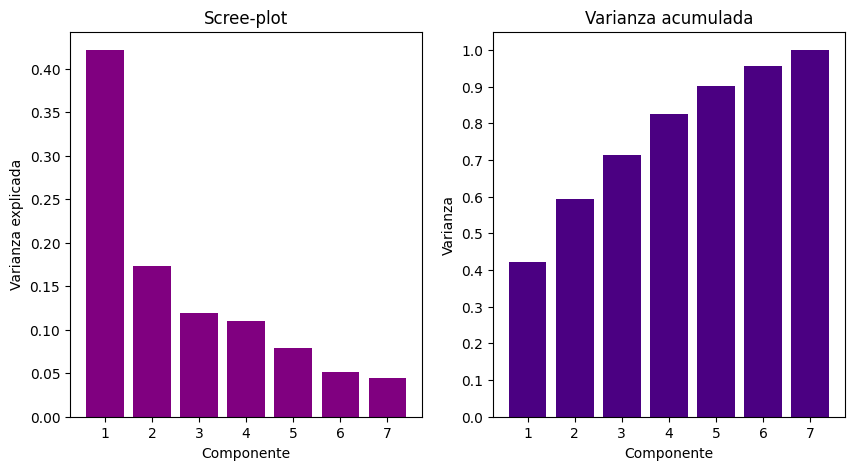

In [7]:
# Analizar la varianza aportada por los componentes
components = np.arange(1, len(pca.components_) + 1)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs.reshape(-1)
axs[0].bar(components, pca.explained_variance_ratio_, color='purple')
axs[0].set_xlabel('Componente')
axs[0].set_ylabel('Varianza explicada')
axs[0].set_xticks(components)
axs[0].set_title(rf"Scree-plot")

variance_cum_sum = np.cumsum(pca.explained_variance_ratio_)
axs[1].bar(components, variance_cum_sum, color='indigo')
axs[1].set_xlabel('Componente')
axs[1].set_ylabel('Varianza')
axs[1].set_xticks(components)
axs[1].set_yticks(np.arange(0, 1.1, 0.1))
axs[1].set_title(rf"Varianza acumulada")

plt.show()

#### Primeras conclusiones
- Para el componente principal PC1, el que aporta la mayor varianza, todas las direcciones apuntar en el mismo sentido. Es decir, este componente está fuertemente relacionado con una variación conjunta de todas las variables a la par, lo que podríamos interpretar como una medida de la productividad total
- El primer componente explica aproximadamente 4 veces más varianza que el segundo y el primero, y con tan solo los primeros 2 podemos explicar el 70% de la varianza de los datos. Sin embargo, necesitamos de al menos 5 de los 7 componentes para explicar el 90% de la varianza

#### Visualización de proyecciones
En esta subsección, se visualizará la proyección de los datos en
 - PC1 vs. PC2
 - Primeros tres PC

 Para cada punto, se asignará un color correspondiente a la fecha en la que se muestreó, indicado en cada gráfico

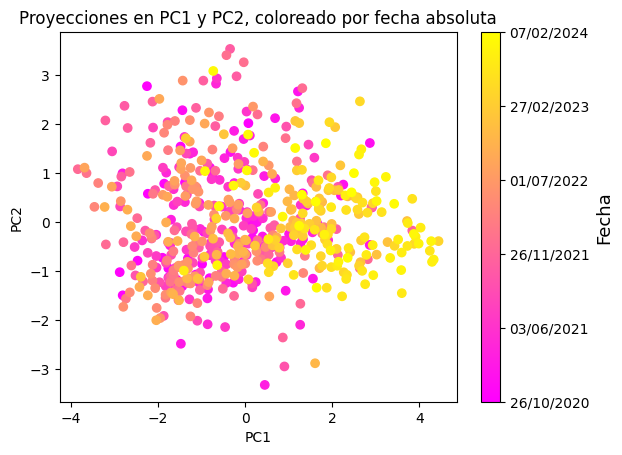

In [8]:
# ploteamos las proyecciones 2D
fig, ax = plt.subplots()
fecha_c = np.arange(len(fechas))
trans_data_scatter = ax.scatter(pca_transformed_data[:,0], pca_transformed_data[:,1], c=fecha_c, cmap='spring')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('Proyecciones en PC1 y PC2, coloreado por fecha absoluta')

clb_ticks = np.arange(0, len(fechas), int(len(fechas)/5))
clb_tick_labels = fechas.dt.strftime('%d/%m/%Y').iloc[clb_ticks]
clb = plt.colorbar(trans_data_scatter, ticks=clb_ticks)
clb.set_label('Fecha',fontsize=13)
clb.ax.set_yticklabels(clb_tick_labels)
plt.show()

Para analizar los efectos de la *estacionalidad* en los datos, vamos a plotear los mismos resultados, pero coloreando según el día del año, desde 0 (primero de enero) hasta 366 (treinta y uno de diciembre). Esto significa que, para el siguiente gráfico, es equivalente el día 01/01/2020 al 01/01/2021, 01/01/2022, y al 01/01/2023, y análogamente para todos los días del año.

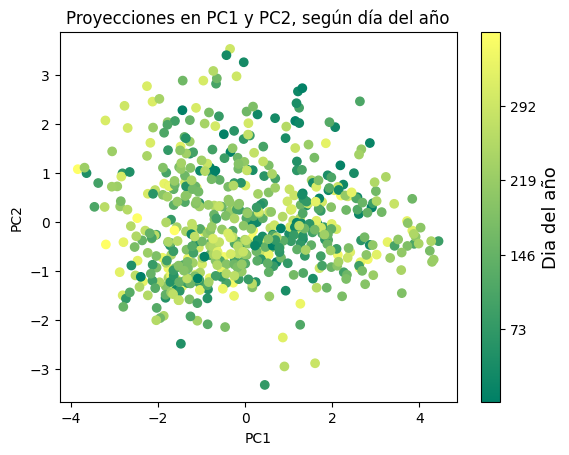

In [9]:
# pasamos de fechas absolutas en 'dd/mm/yyyy' a un int en el rango [0, 366]
days_of_year = fechas.dt.day_of_year

# ploteamos nuevamente
fig, ax = plt.subplots()
fecha_c = np.arange(len(fechas))
trans_data_scatter = ax.scatter(pca_transformed_data[:,0], pca_transformed_data[:,1], c=days_of_year, cmap='summer')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('Proyecciones en PC1 y PC2, según día del año')

clb_doy_ticks = np.arange(0, 367, 366//5)
clb_doy_tick_labels = days_of_year.iloc[clb_ticks]
clb_doy = plt.colorbar(trans_data_scatter, ticks=clb_doy_ticks)
clb_doy.set_label('Dia del año',fontsize=13)
clb.ax.set_yticklabels(clb_doy_tick_labels)
plt.show()

##### Conclusiones de las proyecciones en 2D
Como podemos apreciar, la relación entre el día del año y la injerencia en los PC no es tan clara, casi inexistente. Se puede vislumbrar ligeramente cómo los datos de los valores más extremos de la escala se encuentran acumulados en el centro, y esto podría deberse a que muchos de estos están cercanos en el tiempo (debido a que los últimos días del año N son próximos a los primeros del año N+1). Aún así, no se llega a apreciar un efecto muy marcado para esta coloración.

#### Proyecciones en 3D
Ahora, visualizaremos las proyecciones de los datos en los primeros 3 componentes, analizando nuevamente la injerencia de la fecha

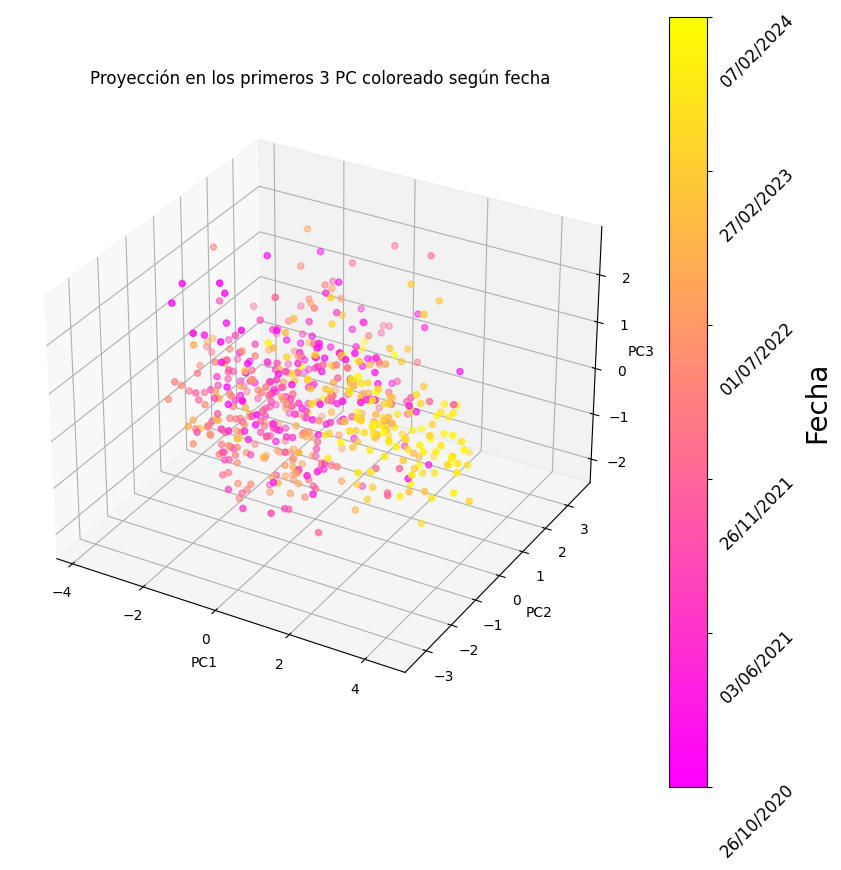

In [10]:
# proyección de datos en 3D
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.set_title('Proyección en los primeros 3 PC coloreado según fecha')
scatter_3D = ax.scatter(pca_transformed_data[:,0], pca_transformed_data[:,1], pca_transformed_data[:,2], c=fecha_c, cmap='spring')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.zaxis.labelpad=-0.7

clb_3D = plt.colorbar(scatter_3D, ticks=clb_ticks)
clb_3D.set_label('Fecha',fontsize=20)
clb_3D.ax.set_yticklabels(clb_tick_labels, fontsize=12, rotation=45)
plt.show()
plt.show()

Nuevamente, se aprecia una clara diferencia entre las muestras más recientes y las más antiguas al colorear por la fecha absoluta. Analizaremos ahora lo que ocurre coloreando por día del año

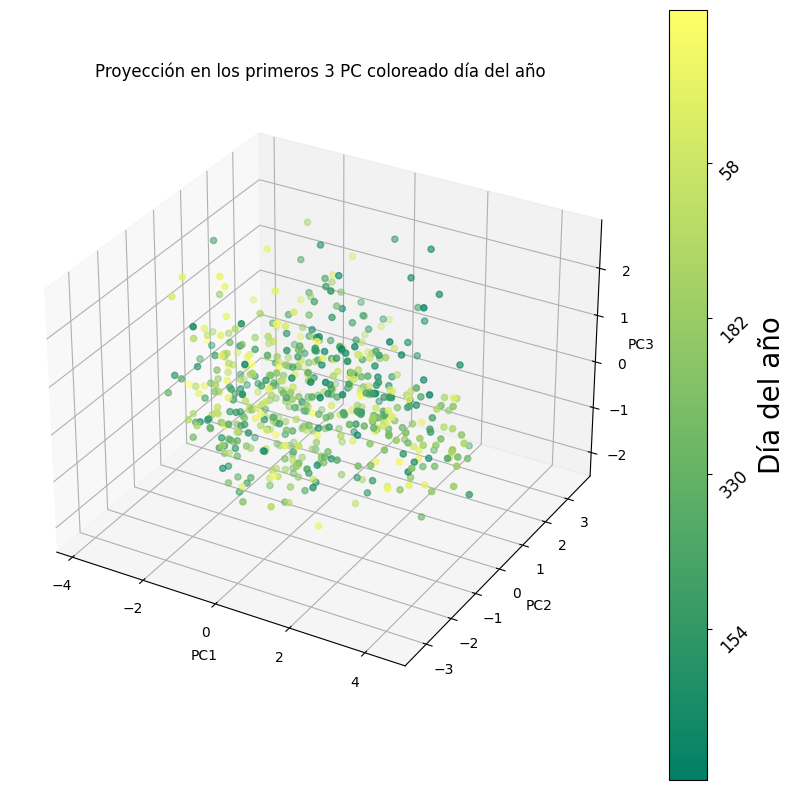

In [11]:
# proyección de datos en 3D
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.set_title('Proyección en los primeros 3 PC coloreado día del año')
scatter_3D = ax.scatter(pca_transformed_data[:,0], pca_transformed_data[:,1], pca_transformed_data[:,2], c=days_of_year, cmap='summer')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.zaxis.labelpad=-0.7

clb_3D = plt.colorbar(scatter_3D, ticks=clb_doy_ticks)
clb_3D.set_label('Día del año',fontsize=20)
clb_3D.ax.set_yticklabels(clb_doy_tick_labels, fontsize=12, rotation=45)
plt.show()

#### Conclusiones finales del análisis por PCA
- El factor determinante de la productividad se da por la variación conjunta de la producción en todas las máquinas, con cierta proporcionalidad que favorece ligeramente a algunas sobre otras, pero siempre en el mismo sentido. Si aumenta la producción de una máquina, es muy probable que aumente proporcionalmente en todas.
- El factor clave que explica el agrupamiento de los datos es la fecha absoluta, siendo los datos más cercanos en el tiempo los más parecidos entre sí
- A lo largo del tiempo, los puntos se fueron "moviendo" primero hacia valores más positivos del PC1. Esto significa una disminución general de la productividad, dado que el vector del PC1 apunta hacia valores negativos en todas las direcciones.
- La estacionalidad de las muestras no parece ser un factor influyente en su varianza. Es decir, no importa tanto el día del año en el que se hayan muestreado los datos, sino que importa más la cercanía temporal entre los mismos. No hay "temporadas altas" o "temporadas bajas" dentro de un mismo año, pero sí hay una tendencia general a la baja en la producción a lo largo del tiempo.

---

### Analisis por T-SNE
Para analizar la performance de t-SNE sobre este dataset, vamos a realizar varios experimentos con distintos niveles de perplexidad


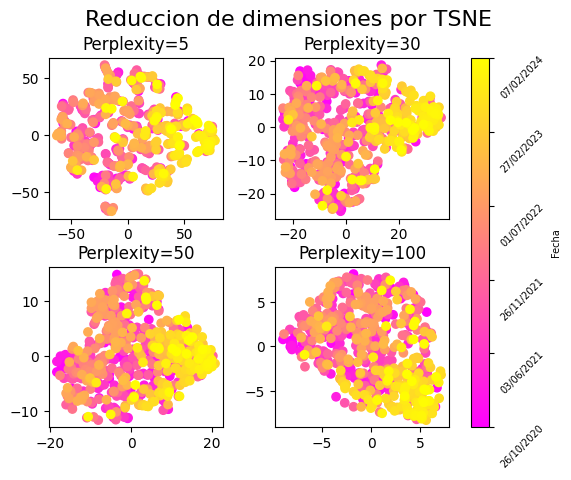

In [12]:
fig, axs = plt.subplots(2, 2)
axs = axs.reshape(-1)
fig.suptitle('Reduccion de dimensiones por TSNE', fontsize=16)
perplexities = [5, 30, 50, 100]

for ax, perp in zip(axs, perplexities):
    tsne = TSNE(2, perplexity=perp)
    tsne_result = tsne.fit_transform(prod_data)
    tsne_scatter = ax.scatter(tsne_result[:, 0], tsne_result[:, 1], c=fecha_c, cmap='spring')
    ax.set_title(f"Perplexity={perp}")

clb = fig.colorbar(tsne_scatter, ax=axs, ticks=clb_ticks)
clb.ax.set_ylabel('Fecha',fontsize=7)
clb.ax.set_yticklabels(clb_tick_labels, fontsize=7, rotation=45)

plt.subplots_adjust(hspace=0.3, right=0.75, wspace=0.3)
plt.show()

Al igual que hicimos con PCA, vamos a visualizar qué ocurre si coloreamos los datos en función del día del año

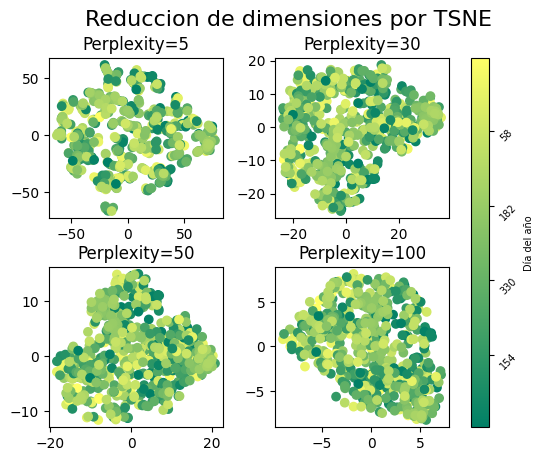

In [13]:
# simulamos nuevamente y coloreamos según día del año
fig, axs = plt.subplots(2, 2)
axs = axs.reshape(-1)
fig.suptitle('Reduccion de dimensiones por TSNE', fontsize=16)
perplexities = [5, 30, 50, 100]

for ax, perp in zip(axs, perplexities):
    tsne = TSNE(2, perplexity=perp)
    tsne_result = tsne.fit_transform(prod_data)
    tsne_scatter = ax.scatter(tsne_result[:, 0], tsne_result[:, 1], c=days_of_year, cmap='summer')
    ax.set_title(f"Perplexity={perp}")

clb = fig.colorbar(tsne_scatter, ax=axs, ticks=clb_doy_ticks)
clb.ax.set_ylabel('Día del año',fontsize=7)
clb.ax.set_yticklabels(clb_doy_tick_labels, fontsize=7, rotation=45)

plt.subplots_adjust(hspace=0.3, right=0.75, wspace=0.3)
plt.show()

#### Conclusiones del análisis por TSNE
Nuevamente, al igual que con PCA, podemos ver cómo los datos más cercanos en el tiempo tienen a agruparse, de modo tal que los puntos más recientes tienden a formar un cluster amarillo. A mayor perplexidad, más notorio se vuelve este efecto. Por otra parte, gran parte de los datos "naranjas" (aproximadamente a la mitad de la escala entre la muestra más antigua y la más reciente) se encuentran superpuestros con los datos "violetas", tal y como sucedía en el análisis por componentes principales.

Al colorear según el día del año, no se aprecia ningún patrón claro, al igual que ocurría en la descomposición por PCA. La estacionalidad no pareciera tener injerencia en estos datos.

Si bien los resultados obtenidos por este método son más marcados en su agrupamiento temporal de los datos que en PCA, cabe destacar que el algoritmo estocástico es mucho más lento que el determinístico. Las simulaciones tomaron, en promedio, hasta 8 veces más que la descomposición en componentes princiaples. Esto podría ser un problema a la hora de analizar datasets más grandes, como por ejemplo lecturas de EEG de cientos de neuronas con cientos de muestras para cada una.

---

### Reduccion de dimensiones por NMF
Al realizar el análisis por PCA, noté que el componente principal tenía todos sus elementos negativos. Me pareció interesante plantear una descomposición distinta que priorize los sentidos positivos en sus direcciones

In [14]:
# Realizar el analisis de NMF con sklearn
N = len(prod_data.columns)
nmf = NMF(n_components=N, max_iter=500)
nmf.fit(prod_data)
nmf_transformed_data = nmf.transform(prod_data)

for idx, component in enumerate(nmf.components_):
    print(f'Component {idx + 1} =')
    print('[', ', '.join([f"{val:.3f}" for val in component]), ']')

Component 1 =
[ 0.000, 0.000, 28.306, 0.000, 0.000, 0.000, 8.403 ]
Component 2 =
[ 0.000, 4.423, 0.000, 4.360, 0.000, 13.800, 2.023 ]
Component 3 =
[ 4.322, 11.393, 0.000, 0.000, 2.019, 0.000, 0.000 ]
Component 4 =
[ 1.989, 0.000, 1.027, 12.318, 1.492, 0.000, 0.006 ]
Component 5 =
[ 0.000, 0.000, 0.000, 0.000, 1.691, 0.000, 10.289 ]
Component 6 =
[ 0.184, 0.000, 2.280, 0.000, 10.173, 0.000, 0.000 ]
Component 7 =
[ 7.742, 0.000, 0.756, 0.000, 0.827, 2.655, 0.393 ]


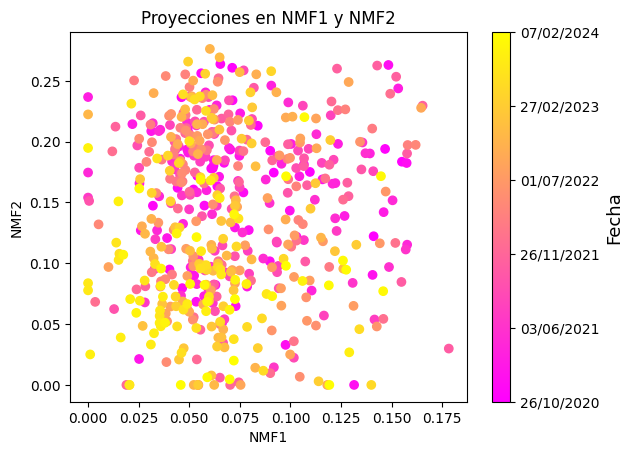

In [15]:
# ploteamos las proyecciones 2D
fig, ax = plt.subplots()
fecha_c = np.arange(len(fechas))
trans_data_scatter = ax.scatter(nmf_transformed_data[:,0], nmf_transformed_data[:,1], c=fecha_c, cmap='spring')
ax.set_xlabel('NMF1')
ax.set_ylabel('NMF2')
ax.set_title('Proyecciones en NMF1 y NMF2')

clb_ticks = np.arange(0, len(fechas), int(len(fechas)/5))
clb_tick_labels = fechas.dt.strftime('%d/%m/%Y').iloc[clb_ticks]
clb = plt.colorbar(trans_data_scatter, ticks=clb_ticks)
clb.set_label('Fecha',fontsize=13)
clb.ax.set_yticklabels(clb_tick_labels)
plt.show()

### Conclusiones del analisis por NMF
Si bien podemos notar nuevamente la incidencia de la fecha en el comportamiento de los datos, es curioso cómo el componente principal calculado por este método es nulo en 5 de las 7 dimensiones originales. Esto podría ser un error numérico de la simulación, aunque los resultados obtenidos son análogos a los de otros métodos de reducción de dimensiones.

Nótese también que, en el análisis por PCA, el PC1 estaba orientado en sentido negativo para todas las variables, y los datos más "amarillos" se encontraban más hacia la derecha. Aquí, estos datos se encuentran más a la izquierda. Esto nos indica, a grandes rasgos, que la dirección del NMF1 es similar a la del PC1, pero en sentido contrario. Esto lo podemos verificar mediante su producto escalar (normalizado por la norma de cada uno):

In [16]:
PC1 = pca.components_[:, 0]
NMF1 = nmf.components_[:, 0]
cos_ang_PC1_NMF1 = np.dot(PC1, NMF1)/(np.linalg.norm(PC1)*np.linalg.norm(NMF1))
print(f"Producto escalar normalizado: {cos_ang_PC1_NMF1:.4f}, Ángulo: {np.arccos(cos_ang_PC1_NMF1)*180/np.pi:.1f}°")

Producto escalar normalizado: -0.7612, Ángulo: 139.6°


El valor del producto escalar normalizado es negativo y cercano a 1, lo que implica una dirección muy similar pero sentidos contrarios.